In [1]:
pip install biopython

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import Align
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import MinMaxScaler
import re
import os
import copy
import pickle
import gzip
import math
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import pygraphviz
import datetime
import statistics
from matplotlib_venn import venn3
#stats
from scipy.signal import find_peaks
from itertools import combinations#
from itertools import combinations_with_replacement
from scipy.stats import linregress
date = datetime.datetime.now().strftime("%Y-%m-%d")
from scipy.stats import ttest_ind
from scipy.stats import chisquare
from scipy.stats import binomtest
from scipy.stats import ttest_rel
#from colorspacious import cspace_converter

In [3]:
def pickle_load(file):
    with gzip.open(file, 'rb') as f:
        print(f'file {file} loaded')
        out=pickle.load(f)
    return out

#character minicircles by gRNA family
def assign_gRNA_fam_to_mini(gRNA_dict,gRNA_families): #use the new version
    mini_dict,cassettes,non_cannonical={},['I','II','III','IV','V','Orphan'],[]
    for g in gRNA_dict:
        if  'Maxi' not in gRNA_dict[g]['mO_name']:
            if gRNA_dict[g]['mO_name'] not in mini_dict:
                mini_dict[gRNA_dict[g]['mO_name']]={c:set() for c in cassettes}
                mini_dict[gRNA_dict[g]['mO_name']][gRNA_dict[g]['cassette_label']].add(g)
            else:
                mini_dict[gRNA_dict[g]['mO_name']][gRNA_dict[g]['cassette_label']].add(g)
    mini_dict.pop('Maxicircle','None') #remove maxicircle      
    mini_df = pd.DataFrame(columns=cassettes,index=mini_dict.keys())
    for mini in mini_dict:
        for c in mini_dict[mini]:
            try:
                mini_df.loc[[mini],[c]]=mini_dict[mini][c]['gRNA_family'][0]
            except:
                non_cannonical.append(f"no cannonical gRNA found in cassette {c} in minicircle {mini}")
    mini_df=mini_df.sort_values(by=cassettes)
    tmp={k:sum([1 for cs in v.values() if cs==set()]) for k,v in mini_dict.items()}
    tmp={k: v for k, v in sorted(tmp.items(), key=lambda item: item[1])}
    ordered=list(tmp.keys())
    mini_dict={k:mini_dict[k] for k in ordered}
    return(mini_dict,mini_df)
#group minicircles by gRNA family
def make_minicircle_family(mini_dict,gRNA_dict):
    mini_families={}
    for mini in mini_dict:
        #put gRNA family to cassettes
        hit=0
        mini_casettes={c: set([i for g in v for i in gRNA_dict[g]['gRNA_family']]) for c,v in mini_dict[mini].items()}
        if mini_families=={}:
            count=1
            mini_families[f"mf{count}"]={'cassettes': mini_casettes,'population':[mini]}
        else:
            for mf,records in mini_families.items():
                test=[0 if set(i) == set(j) else 1 for i,j in zip(mini_casettes.values(),mini_families[mf]['cassettes'].values())]
                if sum(test)==0:
                    mini_families[mf]['population'].append(mini)
                    hit+=1
                    break
            if hit==0: #if no matches were found
                count+=1
                mini_families[f"mf{count}"]={'cassettes': mini_casettes,'population':[mini]}
    #print(mini_families.keys())
    #sort by the number of encoded gRNAs
    tmp={k:sum([1 for cs in v['cassettes'].values() if cs==set()]) for k,v in mini_families.items()}
    tmp={k: v for k, v in sorted(tmp.items(), key=lambda item: item[1])}
    ordered=list(tmp.keys())
    mini_families={k:mini_families[k] for k in ordered}
    print(len(mini_families))
    return(mini_families)

In [4]:
def get_gRNA_info (txt,adjust=0): #build dictionary from gRNA_with_expression files
    with open(txt) as handle:
        keys=[x for x in next(handle).strip('\n').split(' ') if x !='']
        gRNA_dict={f'gRNA_{i}': {i:j for i,j in zip(keys,[x for x in line.strip('\n').split(' ') if x !=''][1:])}for i,line in enumerate(handle)}
        for key in gRNA_dict:
            init_site=int(gRNA_dict[key]['mRNA_end'])+int(gRNA_dict[key]['rel_pos'])
            if gRNA_dict[key]['mRNA_name'] not in ['CYB','MURF2']:
                gRNA_dict[key]['gene_mRNA_end']=init_site+adjust
            else:
                gRNA_dict[key]['gene_mRNA_end']=init_site
    return(gRNA_dict)  
#get deletion and editing seuqences
def read_editing_sites(small_u):
    smallu=SeqIO.to_dict(SeqIO.parse(small_u,'fasta'))
    edits={}
    for k in smallu:
        sites=[0 if b=='u' else 1 for b in smallu[k].seq] #0 for insertions
        edits[k]=sites
    return(edits)
#initiation site counts
def initiation_site_counts(gRNA_dict,small_u):
    insertions=read_editing_sites(small_u)
    mrna0={k:[0]*(len(insertions[k])+20) for k in insertions} #extend the mRNA a bit longer for the initiation sites
    anchors={k:[0]*(len(insertions[k])+20) for k in insertions}
    for k in gRNA_dict:
        init_site=gRNA_dict[k]['gene_mRNA_end']
        anc=int(gRNA_dict[k]['mRNA_start'])
        mrna0[gRNA_dict[k]['mRNA_name']][init_site]+=1
        anchors[gRNA_dict[k]['mRNA_name']][anc]+=1
    return(mrna0,anchors)
#visualize the boundaries
def slide_window_plot(inits,anchors,ws=4,figw=100,figh=50):
    counts={k:[sum(inits[k][i:i+ws]) for i in range(len(inits[k])-ws)] for k in inits} #find initiation sites with window
    counts_a={k:[sum(anchors[k][i:i+ws]) for i in range(len(anchors[k])-ws)] for k in anchors} #find anchor starts with window
    c=0
    def plotting():
        fig,axs = plt.subplots(len(counts),1,figsize=(figw,figh))
        for k in counts:
            ax=axs[c]
            ax.set_title(f'Initiation sites/anchor starts on {k}, window size= {ws}',fontdict={'fontsize': 30, 'fontweight': 30})
            c+=1
            #plot init sites
            ax.plot(range(len(counts[k])),counts[k],label=k)
            #plot anchors
            ax.plot(range(len(counts_a[k])),np.array(counts_a[k])*(-1),label=k)
            #find boundaries
            mrna=''.join([str(i) for i in counts[k]])
            for match in re.finditer('0{5,}',mrna):
                ax.add_patch(Rectangle((match.start(), 0), match.end()-match.start(), max(counts[k])+1,
                                      facecolor = 'black',alpha=0.3))
            #found boundaries with anchors
            mrna=''.join([str(i) for i in counts_a[k]])
            for match in re.finditer('0{3,}',mrna):
                ax.add_patch(Rectangle((match.start(), 0), match.end()-match.start(), (max(counts[k])+1)*(-1),
                                      facecolor = 'black',alpha=0.3))
        plt.show()
    #plotting
    return(counts)
#define gRNA family boundaries
def gRNA_family_boundaries(counts):
    gRNA_families={}
    for k in counts:
        #find boundaries
        mrna=''.join([str(i) for i in counts[k]])
        starts=[match.start() for match in re.finditer('0{5,}',mrna)] #change from 3 to 1
        ends=[match.end() for match in re.finditer('0{5,}',mrna)]
        boundaries=[(i,j) for i,j in zip(ends[:-1],starts[1:])]
        gRNA_families[k]={f'{k}-{pair[0]}_{pair[1]}':{'bound':pair,'gRNA':[],'mRNA':k} for i,pair in enumerate(boundaries)}#
        gRNA_families={m:{k: v for k, v in sorted(gRNA_families[m].items(), key=lambda item: item[1]['bound'][0])} for m in gRNA_families}
        #print(gRNA_families)            
    return(gRNA_families)
#assign gRNA families
def assign_gRNA_families(gRNA_dict,gRNA_families):
    for k in gRNA_dict:
        gRNA_dict[k]['gRNA_family']=[]
        hit=0
        for f in gRNA_families[gRNA_dict[k]['mRNA_name']]:
            bound=gRNA_families[gRNA_dict[k]['mRNA_name']][f]['bound']
            if int(gRNA_dict[k]['gene_mRNA_end']) >= bound[0] and int(gRNA_dict[k]['gene_mRNA_end']) <= bound[1]:
                gRNA_dict[k]['gRNA_family'].append(f)
                gRNA_families[gRNA_dict[k]['mRNA_name']][f]['gRNA'].append(k)
                hit+=1
                break
        if hit==0:
            print(f'error:cannot assign family for {k}')
    return(gRNA_dict,gRNA_families)


In [5]:
#detection of recombination: sharing at least one/two gRNA families and one different
def identify_pairs_similar_mf(mini_families,shared=1,diff=1):
    records,ts,total1=[],{},0
    for i,pair in enumerate(combinations(mini_families.keys(),2)):
        k1,k2=pair[0],pair[1]
        total1+=1
        #print(len(k1))
        #0=empty cassette, 1=homologous cassette, 2=diffeent cassette
        test=[0 if len(c1)==0 or len(c2)==0 else 1 if c1.issubset(c2) or c2.issubset(c1) else 2  # 0: empty/non-canonical, 1: shared, 2: distinct
              for c1,c2 in zip(mini_families[k1]['cassettes'].values(),mini_families[k2]['cassettes'].values())]
        ts[i]=test[:5]
        if ts[i].count(1)>=shared and ts[i].count(2)>=diff:
            records.append({k1:mini_families[k1],k2:mini_families[k2],'hits':ts[i]})
            #print(mini_families[k1]['cassettes'].values(),'\n',mini_families[k2]['cassettes'].values(),test)
    total,allpairs,counts=0,list(ts.keys()),[]
    for i in [0,1,2,3,4,5]:
        for j in [0,1,2,3,4,5]:
            a=[k for k,test in ts.items() if test.count(1)==i and test.count(2)==j]
            print(i,j,len(a),round(len(a)/12561*100,2))
            total+=len(a)
            counts.append(len(a))
    #print(total1,total)
    return(records,counts)
    
def identiy_pairs_similar_mini(mfpairs,cassdict):
    minipairs=[]
    for record in mfpairs:
        k1,k2=list(record.keys())[0],list(record.keys())[1]
        mini1,mini2=record[k1]['population'],record[k2]['population']
        for m1 in mini1:
            cassettes1=[cassdict[f"{m1}_{c}"] 
                        for c,sets in record[k1]['cassettes'].items() if len(sets)!=0 and c!='Orphan']
            for m2 in mini2:
                cassettes2=[cassdict[f"{m2}_{c}"] 
                        for c,sets in record[k2]['cassettes'].items() if len(sets)!=0 and c!='Orphan']
                cassid={}
                for i,j in zip(cassettes1,cassettes2):
                    seq1=i['seq']
                    seq2=j['seq']
                    aligner = Align.PairwiseAligner()
                    seq1,seq2 = aligner.align(seq1,seq2)[0]
                    seqid=round(sum([1 for i,j in zip(seq1,seq2) if i==j])/len(seq1)*100,2)
                    cassid[i['cassette_label']]=seqid                  
                minipairs.append({'m1':m1,'m2':m2,'cassettes_id':cassid,'mf1':k1,'mf2':k2,'hits':record['hits']})
    return(minipairs)
#filter pairs of minicircles
def filter_pairs_similar_mini(minipairs,cut=69.88):
    #part 1 visualize the sequence identity in shared vs distinct cassettes
    def cutoff_stats():
        cutoffs=[69.88,64.46,62.64,60.82,55.37]
        for cutoff in cutoffs:
            tmp=[1 for pair in minipairs 
                 if sum([1 if hit==1 and iden<cutoff else 0 for iden,hit in zip(pair['cassettes_id'].values(),pair['hits'])])==0]
            print(cutoff,len(tmp))
    #cutoff_stats()
    def stats(filtered):
        mf=set([pair['mf1'] for pair in filtered]+[pair['mf2'] for pair in filtered])
        print('number of minicircle families',len(mf))
        mf=set([pair['m1'] for pair in filtered]+[pair['m2'] for pair in filtered])
        print('number of minicircles',len(mf))
    ffiltered1=[pair for pair in minipairs 
             if sum([1 if hit==1 and iden < cut else 0 for iden,hit in zip(pair['cassettes_id'].values(),[i for i in pair['hits'] if i!=0])])==0] #0 if none of the shared  <=cut
    stats(filtered1)
    filtered2=[pair for pair in filtered1 
             if sum([1 if hit==2 and iden >= cut else 0 for iden,hit in zip(pair['cassettes_id'].values(),[i for i in pair['hits'] if i!=0])])==0]#0 if none of the distinct >=cut
    stats(filtered2)
    print(filtered2)
    if len(filtered2) !=0:
        visual(filtered2)
    else:
        print('no satisfied pairs')
    return (filtered2)
def identiy_donor_mini(filtered2,mini_dict,mini_families,cassdict,cutoff=69.88):
    candidate_donors,test={},[]
    for record in filtered2:
        c=[k for k,v in record['cassettes_id'].items() if v<cutoff][0]
        m1,m2=record['m1'],record['m2']
        seq1,seq2=cassdict[f'{m1}_{c}']['seq'],cassdict[f'{m2}_{c}']['seq']
        mf1,mf2=record['mf1'],record['mf2']
        gf1,gf2=set(mini_families[mf1]['cassettes'][c]),set(mini_families[mf2]['cassettes'][c])
        donor1=[(v['population'],cas) for cas in ['I','II','III','IV','V'] for k,v in mini_families.items() if len(set(v['cassettes'][cas]).intersection(gf1))!=0]
        donor2=[(v['population'],cas) for cas in ['I','II','III','IV','V'] for k,v in mini_families.items() if len(set(v['cassettes'][cas]).intersection(gf2))!=0]
        def filter_donors(seq,order,cass,donors,cassdict):
            tmp={'order':order}
            for record in donors:
                c=record[1]
                for donor in record[0]:
                    if f'{donor}_{c}' != cass:
                        donor_seq=cassdict[f'{donor}_{c}']['seq']
                        aligner = Align.PairwiseAligner()
                        seq1,seq2 = aligner.align(seq,donor_seq)[0]
                        seqid=round(sum([1 for i,j in zip(seq1,seq2) if i==j])/len(seq1)*100,2)
                        tmp[f'{donor}_{c}']=seqid
            return(tmp)
        candidate_donors[f'{m1}_{c}']=filter_donors(seq1,1,f'{m1}_{c}',donor1,cassdict)
        candidate_donors[f'{m2}_{c}']=filter_donors(seq2,2,f'{m2}_{c}',donor2,cassdict)
        #test.append(filter_donors(seq1,1,f'{m1}_{c}',donor1,cassdict))
        #test.append(filter_donors(seq2,2,f'{m2}_{c}',donor2,cassdict))
        #print(gf2,donor1)
    return(candidate_donors)

def load_mini(fasta):
    mini_dict=SeqIO.to_dict(SeqIO.parse(fasta,'fasta'))
    #mini_dict={f"{strain}_{k}":v for k,v in mini_dict.items()}
    return(mini_dict)
def get_cassette_info (txt,strain_seq):
    with open(txt) as handle:
        keys=[x for x in next(handle).strip('\n').split(' ') if x !='']
        cassette_dict={f'cassette_{index}': {i:j for i,j in zip(keys,[x for x in line.strip('\n').split(' ') if x !=''][1:])}
                       for index,line in enumerate(handle)}
        cassette_dict={f"{v['mO_name']}_{v['cassette_label']}":{k:int(value) 
                                                                if 'start' in k or 'end' in k else value for k,value in v.items()} 
                       for k,v in cassette_dict.items()}
        for k,v in cassette_dict.items():
            cassette_dict[k]['seq']=strain_seq[f"{cassette_dict[k]['mO_name']}"].seq[v['forward_start']:v['reverse_end']]
    return(cassette_dict)


In [6]:
tbg1mini='/home/jovyan/Minicircle_gRNA_families/In_files/Tbg1_all_clean_minicircles.fasta'
tbgseq=load_mini(tbg1mini)
casstbg='/home/jovyan/Tcongo_PacBio/Infiles/Tbg1_cassettes.txt'
cassdict=get_cassette_info (casstbg,tbgseq)

In [7]:
small_u=f'/home/jovyan/Minicircle_gRNA_families/In_files/Tbg1_Mongo_edited_mRNA_small_u.fasta'
tbg1grna='/home/jovyan/Minicircle_gRNA_families/In_files/Tbg1_gRNAs_2024-05-17.txt'
gRNA_dict=get_gRNA_info (tbg1grna,adjust=0)
inits,anchors,=initiation_site_counts(gRNA_dict,small_u)
counts=slide_window_plot(inits,anchors,ws=1,figw=50,figh=100)
gRNA_families=gRNA_family_boundaries(counts)
gRNA_dict,gRNA_families=assign_gRNA_families(gRNA_dict,gRNA_families)

In [8]:
strain='Tbg1_all'
#pickles=f"/home/jovyan/Minicircle_gRNA_families/Work_files/{strain}/{strain}.pickle"
#tmp=pickle_load(pickles)
mini_dict,mini_df=assign_gRNA_fam_to_mini(gRNA_dict,gRNA_families)
mini_families=make_minicircle_family(mini_dict,gRNA_dict)


159


In [15]:
mini_dict['mO_021']

{'I': {'gRNA_84', 'gRNA_85'},
 'II': {'gRNA_86'},
 'III': set(),
 'IV': {'gRNA_87'},
 'V': {'gRNA_89'},
 'Orphan': {'gRNA_88'}}

In [9]:
def base_line_seq_id_cass_diff_gf(mini_dict,gRNA_dict,cassdict):
    records=[]
    cassettes=['I','II','III','IV','V']
    canonical=[k for k,v in cassdict.items() if v['type']=='canonical' ]
    for pair in combinations(canonical,2):
        k1,k2=pair[0],pair[1]
        m1,m2=cassdict[k1]['mO_name'],cassdict[k2]['mO_name']
        c1,c2=cassdict[k1]['cassette_label'],cassdict[k2]['cassette_label']
        g1,g2=mini_dict[f'{m1}'][c1],mini_dict[f'{m2}'][c2]
        gf1,gf2={gf.split('-')[0] for g in g1 for gf in gRNA_dict[g]['gRNA_family']},{gf.split('-')[0] for g in g2 for gf in gRNA_dict[g]['gRNA_family']}
        if len(gf1.intersection(gf2))==0:
            s1=cassdict[k1]['seq']
            s2=cassdict[k2]['seq']
            aligner = Align.PairwiseAligner()
            s1,s2 = aligner.align(s1,s2)[0]
            seqid=round(sum([1 for i,j in zip(s1,s2) if i==j])/len(s1)*100,2)
            records.append({'cassette1':k1,'cassette2':k2,'id':seqid} )
    return(records)

baseline=base_line_seq_id_cass_diff_gf(mini_dict,gRNA_dict,cassdict)

      label  lower_whisker  lower_quartile  median  upper_quartile  \
0  baseline           57.3           62.07   63.64           65.29   

   upper_whisker  
0          70.12  


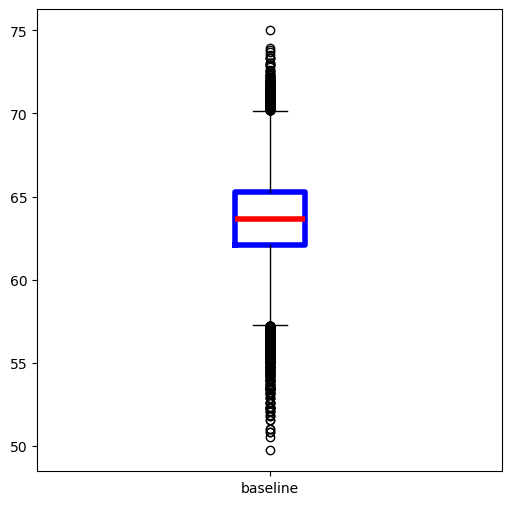

In [10]:
def get_box_plot_data(labels, bp):
    rows_list = []

    for i in range(len(labels)):
        dict1 = {}
        dict1['label'] = labels[i]
        dict1['lower_whisker'] = bp['whiskers'][i*2].get_ydata()[1]
        dict1['lower_quartile'] = bp['boxes'][i].get_ydata()[1]
        dict1['median'] = bp['medians'][i].get_ydata()[1]
        dict1['upper_quartile'] = bp['boxes'][i].get_ydata()[2]
        dict1['upper_whisker'] = bp['whiskers'][(i*2)+1].get_ydata()[1]
        rows_list.append(dict1)

    return pd.DataFrame(rows_list)

def get_bsl_levels(bsl):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6), sharey=False)
    boxprops = dict(linestyle='-', linewidth=4, color='b')
    medianprops = dict(linestyle='-', linewidth=4, color='r')
    labels=['baseline']
    bp=ax.boxplot([bsl],labels=labels,vert=True,boxprops=boxprops,medianprops=medianprops)
    print(get_box_plot_data(labels, bp))

bsl=[d['id'] for d in baseline[:]]
get_bsl_levels(bsl)

In [11]:
#find pairs of minicircle families
mfpairs,counts=identify_pairs_similar_mf(mini_families,shared=2,diff=1)

0 0 1225 9.75
0 1 3741 29.78
0 2 4622 36.8
0 3 2641 21.03
0 4 148 1.18
0 5 0 0.0
1 0 35 0.28
1 1 60 0.48
1 2 58 0.46
1 3 4 0.03
1 4 0 0.0
1 5 0 0.0
2 0 11 0.09
2 1 9 0.07
2 2 1 0.01
2 3 0 0.0
2 4 0 0.0
2 5 0 0.0
3 0 6 0.05
3 1 0 0.0
3 2 0 0.0
3 3 0 0.0
3 4 0 0.0
3 5 0 0.0
4 0 0 0.0
4 1 0 0.0
4 2 0 0.0
4 3 0 0.0
4 4 0 0.0
4 5 0 0.0
5 0 0 0.0
5 1 0 0.0
5 2 0 0.0
5 3 0 0.0
5 4 0 0.0
5 5 0 0.0


In [12]:
#find pairs of minicircles
minipairs=identiy_pairs_similar_mini(mfpairs,cassdict)
print(len(minipairs))

12


71.87 65.89 0.27668182185336687


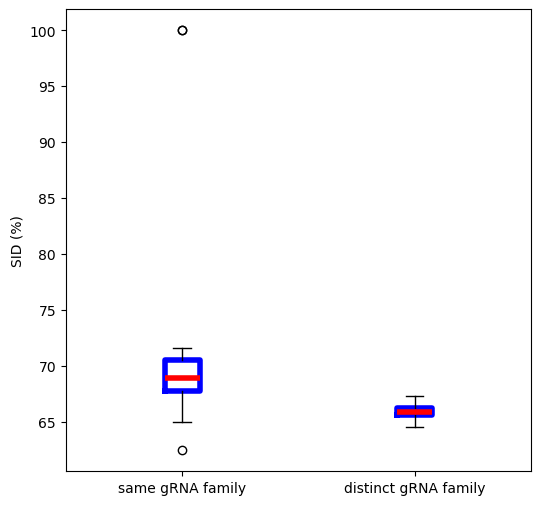

In [13]:
def visual_minipairs(minipairs):
    shared=[iden for pair in minipairs for iden,hit in zip(pair['cassettes_id'].values(),pair['hits']) if hit==1]
    diff=[iden for pair in minipairs for iden,hit in zip(pair['cassettes_id'].values(),pair['hits']) if hit==2]
    a=ttest_ind(shared, diff)
    print(round(sum(shared)/len(shared),2),round(sum(diff)/len(diff),2),a.pvalue)
    data=[shared,diff]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6), sharey=False)
    boxprops = dict(linestyle='-', linewidth=4, color='b')
    medianprops = dict(linestyle='-', linewidth=4, color='r')
    labels=['same gRNA family','distinct gRNA family']
    bp=ax.boxplot(data,labels=labels,vert=True,boxprops=boxprops,medianprops=medianprops)
    ax.set_ylabel('SID (%)')
visual_minipairs(minipairs)

In [16]:
cut=70.12
def stats(filtered):
    mf=set([pair['mf1'] for pair in filtered]+[pair['mf2'] for pair in filtered])
    print('number of minicircle families',len(mf))
    mf=set([pair['m1'] for pair in filtered]+[pair['m2'] for pair in filtered])
    print('number of minicircles',len(mf))
filtered1=[pair for pair in minipairs 
             if sum([1 if hit==1 and iden < cut else 0 for iden,hit in zip(pair['cassettes_id'].values(),[i for i in pair['hits'] if i!=0])])==0] #0 if none of the shared  <=cut
stats(filtered1)
filtered2=[pair for pair in filtered1 
         if sum([1 if hit==2 and iden >= cut else 0 for iden,hit in zip(pair['cassettes_id'].values(),[i for i in pair['hits'] if i!=0])])==0]#0 if none of the distinct >=cut
stats(filtered2)
print(filtered2)

number of minicircle families 2
number of minicircles 3
number of minicircle families 0
number of minicircles 0
[]


71.87 65.89 0.27668182185336687
number of minicircle families 2
number of minicircles 3
number of minicircle families 0
number of minicircles 0
[]
no satisfied pairs


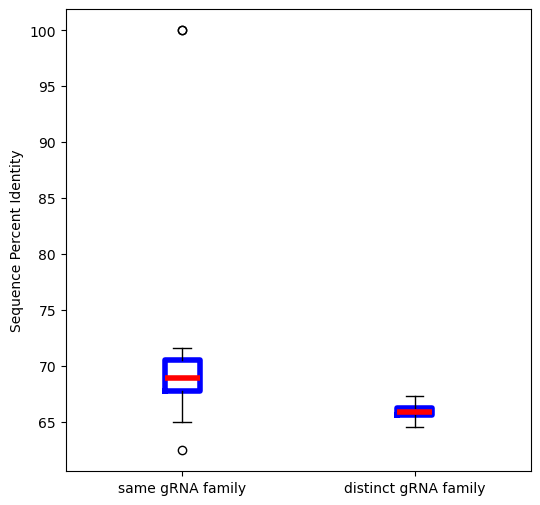

In [61]:
#analysis of minipairs
filtered2=filter_pairs_similar_mini(minipairs,cut=70.12)
#filtered2
#filtered2=filtered2[:-2]

In [32]:
filtered2

[{'m1': 'mO_072',
  'm2': 'mO_073',
  'cassettes_id': {'I': 65.88, 'II': 62.36, 'IV': 59.12},
  'mf1': 'mf11',
  'mf2': 'mf55',
  'hits': [2, 0, 0, 1, 1]},
 {'m1': 'mO_144',
  'm2': 'mO_190',
  'cassettes_id': {'I': 100.0, 'IV': 98.6, 'V': 78.67},
  'mf1': 'mf87',
  'mf2': 'mf97',
  'hits': [1, 0, 0, 1, 2]},
 {'m1': 'mO_144',
  'm2': 'mO_194',
  'cassettes_id': {'I': 100.0, 'IV': 98.6, 'V': 78.67},
  'mf1': 'mf87',
  'mf2': 'mf97',
  'hits': [1, 0, 0, 1, 2]}]

In [41]:
print(mini_families['mf87'],mini_families['mf97'])


{'cassettes': {'I': {'A6_v2-290_291', 'A6_v1-290_291'}, 'II': set(), 'III': set(), 'IV': {'ND7-402_406'}, 'V': {'ND7-923_924'}, 'Orphan': set()}, 'population': ['mO_144']} {'cassettes': {'I': {'A6_v2-290_291', 'A6_v1-290_291'}, 'II': set(), 'III': set(), 'IV': {'ND7-402_406'}, 'V': {'ND7-890_893'}, 'Orphan': set()}, 'population': ['mO_190', 'mO_194']}


[{'m1': 'mO_144',
  'm2': 'mO_190',
  'cassettes_id': {'I': 100.0, 'IV': 98.6, 'V': 78.67},
  'mf1': 'mf87',
  'mf2': 'mf97',
  'hits': [1, 0, 0, 1, 2]},
 {'m1': 'mO_144',
  'm2': 'mO_194',
  'cassettes_id': {'I': 100.0, 'IV': 98.6, 'V': 78.67},
  'mf1': 'mf87',
  'mf2': 'mf97',
  'hits': [1, 0, 0, 1, 2]}]

In [1]:
#cassdict

In [49]:
def identiy_donor_cass(filtered2,mini_dict,mini_families,cassdict,cutoff=69.88):
    candidate_donors,test={},[]
    for record in filtered2:
        c=[k for k,v in record['cassettes_id'].items() if v<cutoff][0]
        print(c)
        m1,m2=record['m1'],record['m2']
        seq1,seq2=cassdict[f'{m1}_{c}']['seq'],cassdict[f'{m2}_{c}']['seq']
        mf1,mf2=record['mf1'],record['mf2']
        gf1,gf2=set(mini_families[mf1]['cassettes'][c]),set(mini_families[mf2]['cassettes'][c])
        donor1=[(v['population'],cas) for cas in ['I','II','III','IV','V'] for k,v in mini_families.items() if len(set(v['cassettes'][cas]).intersection(gf1))!=0]
        donor2=[(v['population'],cas) for cas in ['I','II','III','IV','V'] for k,v in mini_families.items() if len(set(v['cassettes'][cas]).intersection(gf2))!=0]
        def filter_donors(seq,order,cass,donors,cassdict):
            tmp={'order':order}
            for record in donors:
                c=record[1]
                for donor in record[0]:
                    if f'{donor}_{c}' != cass:
                        donor_seq=cassdict[f'{donor}_{c}']['seq']
                        aligner = Align.PairwiseAligner()
                        seq1,seq2 = aligner.align(seq,donor_seq)[0]
                        seqid=round(sum([1 for i,j in zip(seq1,seq2) if i==j])/len(seq1)*100,2)
                        tmp[f'{donor}_{c}']=seqid
            return(tmp)
        candidate_donors[f'{m1}_{c}']=filter_donors(seq1,1,f'{m1}_{c}',donor1,cassdict)
        candidate_donors[f'{m2}_{c}']=filter_donors(seq2,2,f'{m2}_{c}',donor2,cassdict)
        #test.append(filter_donors(seq1,1,f'{m1}_{c}',donor1,cassdict))
        #test.append(filter_donors(seq2,2,f'{m2}_{c}',donor2,cassdict))
        #print(gf2,donor1)
    return(candidate_donors)

In [50]:
candidate_donors=identiy_donor_cass(minipairs[-2:],mini_dict,mini_families,cassdict,cutoff=80)

V
V


In [52]:
candidate_donors

{'mO_144_V': {'order': 1, 'mO_067_V': 67.24},
 'mO_190_V': {'order': 2, 'mO_020_IV': 63.35, 'mO_194_V': 100.0},
 'mO_194_V': {'order': 2, 'mO_020_IV': 63.35, 'mO_190_V': 100.0}}

In [51]:
print(len(candidate_donors))
cutoff=69.88
hqdonors={k:{d:iden for d,iden in v.items() if iden >=cutoff} for k,v in candidate_donors.items() }
hqdonors={k:v for k,v in hqdonors.items() if len(v)!=0}
print('cass with candidate donors',len(hqdonors))
multidonors=[k for k,v in hqdonors.items() if len(v)>1]
print('cass with multiple donors',len(multidonors))
topdonors={k:{d:iden for d,iden in v.items() if iden == max(list(v.values()))} for k,v in hqdonors.items()}
topdonorid=[iden for v in topdonors.values() for iden in v.values()]
print(max(topdonorid),min(topdonorid),sum(topdonorid)/len(topdonorid))
highlysimilardonor={k:{d:iden for d,iden in v.items() if iden >95} for k,v in hqdonors.items()}

3
cass with candidate donors 2
cass with multiple donors 0
100.0 100.0 100.0
